# 1 Обработка данных

In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.7 MB/s eta 0:00:00


In [73]:
from google.colab import drive
import os


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from urllib.request import urlretrieve

from Bio import SeqIO

import torch
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib
from lightgbm import LGBMClassifier

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# проверка ресурсов
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.device_count())
print(torch.cuda.is_available())

12.4
90300
1
True


In [57]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


## 1.1 Загрузка и очистка

In [8]:
# скачиваем базу данных skempi_v2 в формате csv
skempi_file_path = 'skempi_v2.csv'

if not os.path.isfile(skempi_file_path):
  urlretrieve('https://life.bsc.es/pid/skempi2/database/download/skempi_v2.csv', skempi_file_path)

In [9]:
# загружаем данные
data = pd.read_csv('skempi_v2.csv', sep=';')
print(data.columns)
data

Index(['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins',
       'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)',
       'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2',
       'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
       'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))',
       'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed',
       'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
       'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes',
       'Method', 'SKEMPI version'],
      dtype='object')


,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,...,koff_mut_parsed,koff_wt (s^(-1)),koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7080,3QIB_ABP_CD,KP9R,KP8R,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",2.4E-04,2.400000e-04,5.5E-06,5.500000e-06,...,0.500,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2
7081,3QIB_ABP_CD,TP12A,TP11A,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",>1.1E-03,1.100000e-03,5.5E-06,5.500000e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPR,2
7082,3QIB_ABP_CD,TP12S,TP11S,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",3.38E-05,3.380000e-05,5.5E-06,5.500000e-06,...,0.134,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2
7083,3QIB_ABP_CD,TP12N,TP11N,COR,TCR/pMHC,"TCR/pMHC,1JCK_A_B",4.34E-05,4.340000e-05,5.5E-06,5.500000e-06,...,0.175,2.2E-02,0.022,NaN,NaN,NaN,NaN,NaN,SPR,2


## 1.2 Расчёт ddG

Согласно FAQ SKEMPI 2.0 будем считать изменение энергии Гиббса $ \Delta G $ по соотношению:
$$ \Delta G = RT\ln K_d $$

In [10]:
# убираем текстовые комментарии из столбца значений температуры и аффинностей
data['Temperature'] = data['Temperature'].str.extract(r'(\d+)').astype(float)
data['Affinity_mut (M)'] = data['Affinity_mut (M)'].str.extract(r'(\d+)').astype(float)
data['Affinity_wt (M)'] = data['Affinity_wt (M)'].str.extract(r'(\d+)').astype(float)

In [11]:
R = 8.314 / 4184
data['ddG'] = R * data['Temperature'] * (np.log(data['Affinity_mut (M)'].astype(float)) - np.log(data['Affinity_wt (M)'].astype(float)))

# оставляем только нужные столбцы и убираем строки с пустыми ячейками
data = data[['#Pdb', 'Mutation(s)_cleaned', 'ddG']].dropna().reset_index(drop=True)

# проверяем очищенные данные
data

,#Pdb,Mutation(s)_cleaned,ddG
0,1CSE_E_I,LI38G,0.940243
1,1CSE_E_I,LI38S,1.214821
2,1CSE_E_I,LI38P,0.000000
3,1CSE_E_I,LI38I,0.000000
4,1CSE_E_I,LI38D,0.000000
...,...,...,...
6789,3QIB_ABP_CD,KP8R,-0.542585
6790,3QIB_ABP_CD,TP11A,-0.953035
6791,3QIB_ABP_CD,TP11S,-0.302487
6792,3QIB_ABP_CD,TP11N,-0.132135


## 1.3 Анализ распределения ddG

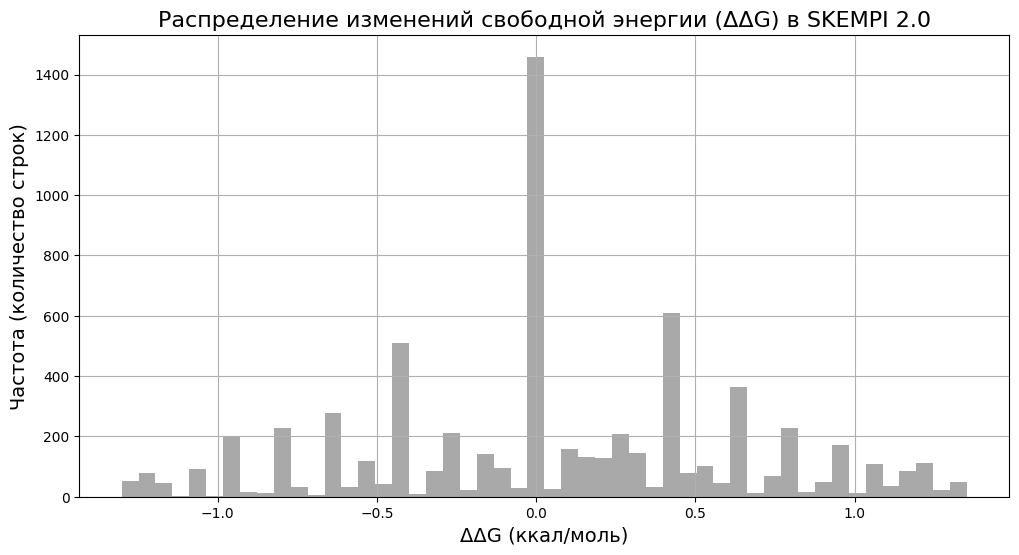

In [12]:
plt.figure(figsize=(12, 6))
plt.hist(data['ddG'], bins=50, color='darkgray')
plt.title('Распределение изменений свободной энергии (ΔΔG) в SKEMPI 2.0', fontsize=16)
plt.xlabel('ΔΔG (ккал/моль)', fontsize=14)
plt.ylabel('Частота (количество строк)', fontsize=14)
plt.grid(True)
plt.show()

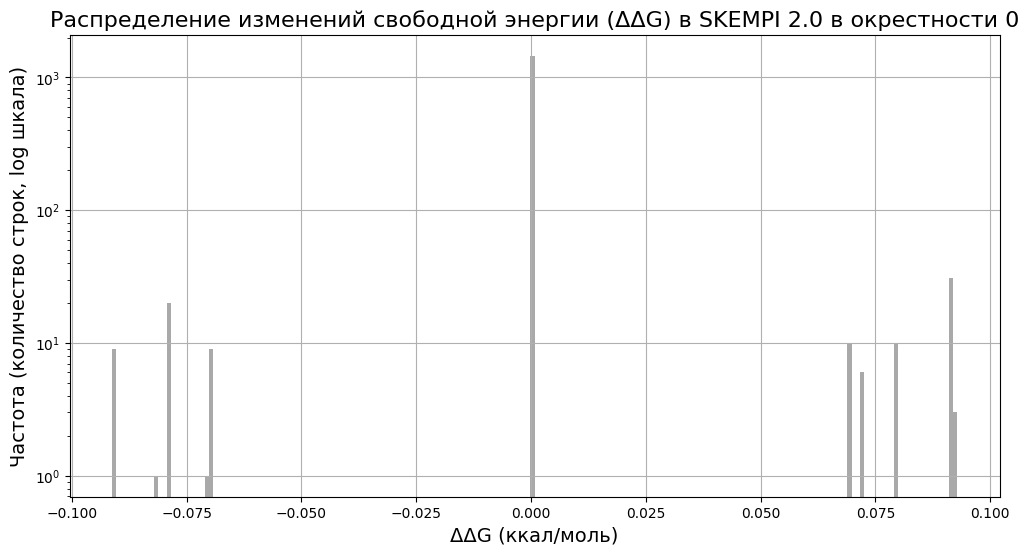

In [13]:
abs_bound = 0.1

plt.figure(figsize=(12, 6)).gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist((data[abs(data['ddG']) <= abs_bound])['ddG'], bins=200, color='darkgray')
plt.title('Распределение изменений свободной энергии (ΔΔG) в SKEMPI 2.0 в окрестности 0', fontsize=16)
plt.xlabel('ΔΔG (ккал/моль)', fontsize=14)
plt.ylabel('Частота (количество строк, log шкала)', fontsize=14)
plt.yscale('log')
plt.grid(True)
plt.show()

In [14]:
data[data['ddG'] == 0].count()

,0
#Pdb,1459
Mutation(s)_cleaned,1459
ddG,1459


Видим, что в датасете очень много строк, для которых изменение свободной энергии было бы нулевым. Удалять ничего не будем.

In [15]:
# добавляем столбец с целевой переменной
data['y'] = np.sign(data['ddG']).astype('int')
data

,#Pdb,Mutation(s)_cleaned,ddG,y
0,1CSE_E_I,LI38G,0.940243,1
1,1CSE_E_I,LI38S,1.214821,1
2,1CSE_E_I,LI38P,0.000000,0
3,1CSE_E_I,LI38I,0.000000,0
4,1CSE_E_I,LI38D,0.000000,0
...,...,...,...,...
6789,3QIB_ABP_CD,KP8R,-0.542585,-1
6790,3QIB_ABP_CD,TP11A,-0.953035,-1
6791,3QIB_ABP_CD,TP11S,-0.302487,-1
6792,3QIB_ABP_CD,TP11N,-0.132135,-1


# 2 Получение признаков

## 2.1 Получение wt последовательностей

In [16]:
def parse_pdb_name(name):
    parts = name.split('_')
    pdb_code = parts[0]
    prefix = parts[1]
    suffix = parts[2]

    chain_1 = prefix[0]
    chain_2 = prefix[1] if len(prefix) == 2 else ''

    chain_3 = suffix[0]
    chain_4 = suffix[1] if len(suffix) == 2 else ''

    return pd.Series([pdb_code, chain_1, chain_2, chain_3, chain_4])

In [17]:
# извлекаем PDB коды и названия цепей для белков
data[['PDB_code', 'chain_1', 'chain_2', 'chain_3', 'chain_4']] = data['#Pdb'].apply(parse_pdb_name)

data['PDB_code'] = data['#Pdb'].str[:4]
data['chain_1'] = data['#Pdb'].str[5]
data['chain_2'] = data['#Pdb'].apply(lambda s: s[6] if s[6] != '_' else '')
data['chain_3'] = data['#Pdb'].apply(lambda s: s[s.rfind('_') + 1])
data['chain_4'] = data['#Pdb'].apply(lambda s: s[s.rfind('_') + 2] if s.rfind('_') + 2 < len(s) else '')
data

,#Pdb,Mutation(s)_cleaned,ddG,y,PDB_code,chain_1,chain_2,chain_3,chain_4
0,1CSE_E_I,LI38G,0.940243,1,1CSE,E,,I,
1,1CSE_E_I,LI38S,1.214821,1,1CSE,E,,I,
2,1CSE_E_I,LI38P,0.000000,0,1CSE,E,,I,
3,1CSE_E_I,LI38I,0.000000,0,1CSE,E,,I,
4,1CSE_E_I,LI38D,0.000000,0,1CSE,E,,I,
...,...,...,...,...,...,...,...,...,...
6789,3QIB_ABP_CD,KP8R,-0.542585,-1,3QIB,A,B,C,D
6790,3QIB_ABP_CD,TP11A,-0.953035,-1,3QIB,A,B,C,D
6791,3QIB_ABP_CD,TP11S,-0.302487,-1,3QIB,A,B,C,D
6792,3QIB_ABP_CD,TP11N,-0.132135,-1,3QIB,A,B,C,D


In [18]:
def get_aa_seq(PDB_code, PDB_chain):
    if not PDB_chain:
        return ""

    query_chain_id = f'{PDB_code}:{PDB_chain}'
    PDB_file_path = f'PDB/{PDB_code}.pdb'

    if not os.path.isfile(PDB_file_path):
        urlretrieve(f'http://files.rcsb.org/download/{PDB_code}.pdb', PDB_file_path)

    return str(({record.id: record.seq for record in SeqIO.parse(PDB_file_path, 'pdb-seqres')})[query_chain_id])

In [19]:
# получаем аминокислотные последовательности
PDB_dir_path = './PDB'
os.makedirs(PDB_dir_path, exist_ok=True)

data['wt_seq_1'] = data.apply(lambda x: get_aa_seq(x.PDB_code, x.chain_1), axis=1)
data['wt_seq_2'] = data.apply(lambda x: get_aa_seq(x.PDB_code, x.chain_2), axis=1)
data['wt_seq_3'] = data.apply(lambda x: get_aa_seq(x.PDB_code, x.chain_3), axis=1)
data['wt_seq_4'] = data.apply(lambda x: get_aa_seq(x.PDB_code, x.chain_4), axis=1)

data

,#Pdb,Mutation(s)_cleaned,ddG,y,PDB_code,chain_1,chain_2,chain_3,chain_4,wt_seq_1,wt_seq_2,wt_seq_3,wt_seq_4
0,1CSE_E_I,LI38G,0.940243,1,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,
1,1CSE_E_I,LI38S,1.214821,1,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,
2,1CSE_E_I,LI38P,0.000000,0,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,
3,1CSE_E_I,LI38I,0.000000,0,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,
4,1CSE_E_I,LI38D,0.000000,0,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6789,3QIB_ABP_CD,KP8R,-0.542585,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...
6790,3QIB_ABP_CD,TP11A,-0.953035,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...
6791,3QIB_ABP_CD,TP11S,-0.302487,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...
6792,3QIB_ABP_CD,TP11N,-0.132135,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...


## 2.2 Получение mut последовательностей

In [20]:
def apply_mutations(row):
    mut_seqs = {
        row['chain_1']: list(row['wt_seq_1']),
        row['chain_2']: list(row['wt_seq_2']) if row['chain_2'] else [],
        row['chain_3']: list(row['wt_seq_3']) if row['chain_3'] else [],
        row['chain_4']: list(row['wt_seq_4']) if row['chain_4'] else []
    }

    mutations = row['Mutation(s)_cleaned'].split(',')
    for mut in mutations:
        if len(mut) < 4:
            continue
        wt_res = mut[0]
        chain = mut[1]
        mut_res = mut[-1]
        try:
            pos = int(mut[2:-1]) - 1
        except ValueError:
            continue

        if chain in mut_seqs and 0 <= pos < len(mut_seqs[chain]):
            mut_seqs[chain][pos] = mut_res

    return pd.Series([
        ''.join(mut_seqs.get(row['chain_1'], [])),
        ''.join(mut_seqs.get(row['chain_2'], [])),
        ''.join(mut_seqs.get(row['chain_3'], [])),
        ''.join(mut_seqs.get(row['chain_4'], []))
    ])

In [21]:
# добавляем последовательности с мутациями
data[['mut_seq_1', 'mut_seq_2', 'mut_seq_3', 'mut_seq_4']] = data.apply(apply_mutations, axis=1)
data

,#Pdb,Mutation(s)_cleaned,ddG,y,PDB_code,chain_1,chain_2,chain_3,chain_4,wt_seq_1,wt_seq_2,wt_seq_3,wt_seq_4,mut_seq_1,mut_seq_2,mut_seq_3,mut_seq_4
0,1CSE_E_I,LI38G,0.940243,1,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLGEGSPVTLD...,
1,1CSE_E_I,LI38S,1.214821,1,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLSEGSPVTLD...,
2,1CSE_E_I,LI38P,0.000000,0,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,
3,1CSE_E_I,LI38I,0.000000,0,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLIEGSPVTLD...,
4,1CSE_E_I,LI38D,0.000000,0,1CSE,E,,I,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLDEGSPVTLD...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6789,3QIB_ABP_CD,KP8R,-0.542585,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...
6790,3QIB_ABP_CD,TP11A,-0.953035,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...
6791,3QIB_ABP_CD,TP11S,-0.302487,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...
6792,3QIB_ABP_CD,TP11N,-0.132135,-1,3QIB,A,B,C,D,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...,IKEEHTIIQAEFYLLPDKRGEFMFDFDGDEIFHVDIEKSETIWRLE...,GSGGGGSRPWFLEYCKSECHFYNGTQRVRLLVRYFYNLEENLRFDS...,MRGDQVEQSPSALSLHEGTGSALRCNFTTTMRAVQWFQQNSRGSLI...,MANERADLIAYLKQATKGGGGSGGGGGMKVIQTPRYLVKGQGQKAK...


# 3 Обучение модели

## 3.1 Эмбеддинг последовательностей

In [22]:
# загрузка ESM-1v эмбеддинга
model, alphabet = torch.hub.load('facebookresearch/esm:main', 'esm1v_t33_650M_UR90S_1')

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1v_t33_650M_UR90S_1.pt" to /root/.cache/torch/hub/checkpoints/esm1v_t33_650M_UR90S_1.pt
/root/.cache/torch/hub/facebookresearch_esm_main/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [34]:
batch_converter = alphabet.get_batch_converter()
device = torch.device('cuda')
model = model.to(device)
model.eval()

ProteinBertModel(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 1280, padding_idx=1)


In [35]:
def embed_sequence(seq):
    if not seq or pd.isna(seq) or seq.strip() == '':
        return torch.zeros(1280, device='cpu')

    batch_labels, batch_strs, batch_tokens = batch_converter([('protein', seq)])
    batch_tokens = batch_tokens.to(device)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)

    token_representations = results['representations'][33].squeeze(0)
    return token_representations[1:len(seq)+1].mean(0).cpu()

In [36]:
def process_row(row):
    emb = []
    for wt_col, mut_col in zip(['wt_seq_1', 'wt_seq_2', 'wt_seq_3', 'wt_seq_4'],
                               ['mut_seq_1', 'mut_seq_2', 'mut_seq_3', 'mut_seq_4']):
        wt_emb = embed_sequence(row[wt_col])
        mut_emb = embed_sequence(row[mut_col])
        emb.append(torch.cat([wt_emb, mut_emb]))
    return torch.cat(emb)

In [37]:
# esm работает только с последовательностями до 1024 аминокислот
def check_len(row):
  esm_limit_len = 1024
  return len(row['wt_seq_1']) <= esm_limit_len \
      and len(row['wt_seq_2']) <= esm_limit_len \
      and len(row['wt_seq_3']) <= esm_limit_len \
      and len(row['wt_seq_4']) <= esm_limit_len \
      and len(row['mut_seq_1']) <= esm_limit_len \
      and len(row['mut_seq_2']) <= esm_limit_len \
      and len(row['mut_seq_3']) <= esm_limit_len \
      and len(row['mut_seq_4']) <= esm_limit_len

In [42]:
# запускаем эмбеддинг, если ещё этого не сделали
features_file_path = 'features.csv'

if not os.path.isfile(features_file_path):
  features = []
  y = []

  for _, row in tqdm(data.iterrows(), total=len(data)):
      if (check_len(row)):
        features.append(process_row(row))
        y.append(row['y'])

  X = torch.stack(features).numpy()
  np.savetxt(features_file_path, X, delimiter=',')
else:
  X = np.loadtxt(features_file_path, delimiter=',')
  y = data[data.apply(lambda row: check_len(row), axis=1)]['y']

100%|██████████| 6794/6794 [55:57<00:00,  2.02it/s]


In [43]:
X.shape

(6736, 10240)

## 3.2 Обучение модели

In [44]:
# разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [45]:
# посмотрим на сдвиги и шкалирование
print(X_train.shape)
print(X_train.min(), X_train.max(), X_train.mean(), np.median(X_train))

(5388, 10240)
-3.5341737 29.217196 0.0050963103 0.0


In [58]:
# обучаем модель, если ещё этого не сделали
model_file_path = 'logistic_regression_ddG_model.pkl'

if not os.path.isfile(model_file_path):
  clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
  clf.fit(X_train, y_train)
  joblib.dump(clf, model_file_path)
else:
  clf = joblib.load(model_file_path)

Заметим, что sklearn по умолчанию использует L2-регуляризацию. Использовать L1 мы не стали, так как аминокислотные последовательности в используемой базе данных слишком разнообразны и задача отбора признаков не стоит.

# 4 Результаты и выводы

## 4.1 Попытки улучшить модель (время и вычислительные ресурсы ограничены)

In [59]:
# проверяем качество классификации
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'min weight value is {clf.coef_.min()}, max weight value is {clf.coef_.max()}, mean is {clf.coef_.mean()}')

              precision    recall  f1-score   support

          -1       0.59      0.64      0.62       467
           0       0.41      0.10      0.17       286
           1       0.55      0.71      0.62       595

    accuracy                           0.56      1348
   macro avg       0.52      0.49      0.47      1348
weighted avg       0.53      0.56      0.52      1348

min weight value is -0.4940035406371805, max weight value is 0.4259561975606896, mean is -1.0141627121429408e-16


К сожалению, добиться сходимости не удалось, однако модель показала себя неплохо. Веса получились не слишком большие.

Попробуем улучшить модель, изменив алгоритм логистической регрессии, добавив шкалирование и L1-регуляризацию.

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [65]:
# обучаем модель, если ещё этого не сделали
model_v2_file_path = 'logistic_regression_ddG_model_improved.pkl'

if not os.path.isfile(model_v2_file_path):
  clf_v2 = LogisticRegression(multi_class='multinomial', max_iter=1000, \
                            solver='saga', random_state=42, \
                            penalty='elasticnet', l1_ratio=0.1)
  clf_v2.fit(X_scaled, y_train)
  joblib.dump(clf_v2, model_v2_file_path)
else:
  clf_v2 = joblib.load(model_v2_file_path)

In [66]:
y_pred = clf_v2.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'min weight value is {clf_v2.coef_.min()}, max weight value is {clf_v2.coef_.max()}, mean is {clf_v2.coef_.mean()}')

              precision    recall  f1-score   support

          -1       0.51      0.73      0.60       467
           0       0.00      0.00      0.00       286
           1       0.55      0.63      0.59       595

    accuracy                           0.53      1348
   macro avg       0.35      0.45      0.40      1348
weighted avg       0.42      0.53      0.47      1348

min weight value is -0.2120945006608963, max weight value is 0.17828477919101715, mean is 1.65420333360089e-05


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


К сожалению, модель показала себя хуже. Заметим, что на самом деле вносить изменения в модель нужно последовательно, а не все разом, однако в силу ограниченности доступного времени пользования вычислительными ресурсами Google Colab пришлось значительно изменить алгоритм сразу.

В качестве возможных улучшений можно предложить последовательный подбор регуляризации, а также алгоритма логистической регрессии и его параметров.

Кроме того, можно попробовать градиентный бустинг

In [70]:
# обучаем модель, если ещё этого не сделали
gbm_file_path = 'gradient_boosting_ddG_model.pkl'

if not os.path.isfile(gbm_file_path):
  gbm = LGBMClassifier(class_weight='balanced', random_state=42)
  gbm.fit(X_train, y_train)
  joblib.dump(clf_v2, gbm_file_path)
else:
  gbm = joblib.load(gbm_file_path)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.940137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1796499
[LightGBM] [Info] Number of data points in the train set: 5388, number of used features: 10240
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [71]:
y_pred = gbm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.69      0.63       467
           0       0.35      0.35      0.35       286
           1       0.61      0.52      0.56       595

    accuracy                           0.54      1348
   macro avg       0.51      0.52      0.51      1348
weighted avg       0.55      0.54      0.54      1348



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 4.2 Идеи и сравнение с Rosetta

Далее можно посмотреть на нейросетевые алгоритмы. Начать можно со многослойного персептрона, постепенно усложняя модель и добавляя механизмы внимания для более аккуратной работы с контекстом мутаций. Также следует учитывать физико-химические свойства как мутировавших остатков, так и их контекст, а также изменения в четвертичной структуре белка.

Сравнить нашу модель можно с известной моделью от Rosetta (https://doi.org/10.1101/2022.09.02.506350).
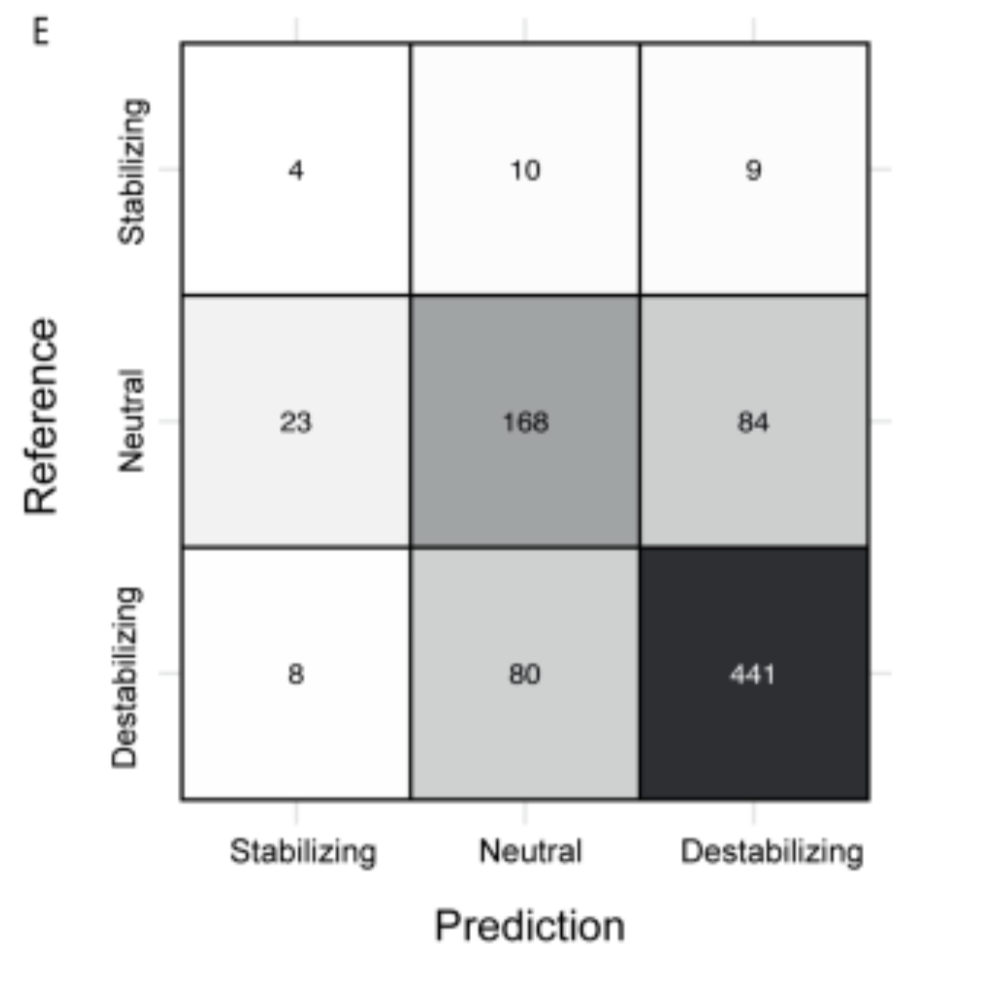

В статье авторы используют протоколы Rosetta для предсказания изменения свободной энергии Гиббса как для мономеров, так и для белковых комплексов. Эти подходы также можно включить в модель для повышения точности.  